# Neural Network for CLA Project

## Import statements

In [1]:
from sklearn import preprocessing
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import errno
import os
import sys
import Constants
import copy

## Hyperparameters

In [2]:
# data processing
sample_bias = 0     # adjust the difference in the number of the two types of samples (no algae vs algae)
test_size = 0.2
batch_size = 96    # batch size for the DataLoaders. previously was 100

# NN model
num_features = 17
input_size = num_features     # size of input layer
multiplier = 100         # multiplied by num_features to determine the size of each hidden layer. previously was 100
hidden_size = multiplier * input_size
output_size = 1
learning_rate = 0.001         # learning rate of optimizer. previously was 0.01
num_epochs = 100                # number of epochs

## Read in data

In [3]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix

# define data and destination paths
dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
data_set = "data_2017_summer"

# load data sets
X = np.load(data_path + data_set + ".npy")
y = np.load(data_path + data_set + "_labels.npy")

# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: -1 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# oversample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
idx = 0
sample_bias = 0
length_y = len(y)
while num_alg != (num_no_alg + sample_bias):
    # circle through the data sets until the difference of num_no_alg and num_alg equals
    # the value specified by sample_bias
    if idx == (length_y - 1):
        idx = 0

    if y[idx] == 1:
        if np.random.rand() >= 0.5:  # add this sample with some probability
            y = np.append(y, y[idx])
            X = np.append(X, np.reshape(X[idx, :], newshape=(1, num_features)), axis=0)
            num_alg += 1
        else:
            idx += 1
    else:
        idx += 1

### Process and split data set

In [4]:
# standardize data: remove the mean and variance in each sample
num_splits = 2   # do not change
sss = model_selection.StratifiedShuffleSplit(n_splits=num_splits, test_size=test_size)

idx, _ = sss.split(X, y);
train_idx = idx[0]
test_idx = idx[1]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)

# np.save(dest_path + "X_train_curve.npy", X_train)
# np.save(dest_path + "X_test_curve.npy", X_test)
# np.save(dest_path + "y_train_curve.npy", y_train)
# np.save(dest_path + "y_test_curve.npy", y_test)

# convert numpy arrays to pytorch tensors
train_set_size = X_train.shape
test_set_size = X_test.shape
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

# convert pytorch tensors to pytorch TensorDataset
train_set = utils.TensorDataset(X_train, y_train)
test_set = utils.TensorDataset(X_test, y_test)

# create DataLoaders
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = utils.DataLoader(test_set, batch_size=test_set_size[0], shuffle=True)

# torch.save(train_loader, dest_path + "train_loader_curve.pt")
# torch.save(test_loader, dest_path + "test_loader_curve.pt")

## Define neural network model

In [5]:
class CLANet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CLANet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, output_size)     # previously, this was output_size
#         self.tanh6 = nn.Tanh()                             # previously, this was the line which was commented out
#         self.fc7 = nn.Linear(hidden_size, output_size)
#         self.relu7 = nn.ReLU()
#         self.fc8 = nn.Linear(hidden_size, hidden_size)
#         self.relu8 = nn.ReLU()
#         self.fc9 = nn.Linear(hidden_size, output_size)
#         self.relu9 = nn.ReLU()
#         self.fc10 = nn.Linear(hidden_size, hidden_size)
#         self.relu10 = nn.ReLU()
#         self.fc11 = nn.Linear(hidden_size, hidden_size)
#         self.relu11 = nn.ReLU()
#         self.fc12 = nn.Linear(hidden_size, output_size)
        self.sig1 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.tanh4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
#         out = self.tanh6(out)
#         out = self.fc7(out)
#         out = self.relu7(out)
#         out = self.fc8(out)
#         out = self.relu8(out)
#         out = self.fc9(out)
#         out = self.relu9(out)
#         out = self.fc10(out)
#         out = self.relu10(out)
#         out = self.fc11(out)
#         out = self.relu11(out)
#         out = self.fc12(out)
        out = self.sig1(out)
        return out

### Instantiate the neural network

In [6]:
model = CLANet(input_size, hidden_size, output_size)
criterion = nn.BCELoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=1, dampening=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
model.double();     # cast model parameters to double

## Train the neural network

In [16]:
model.train()     # training mode
training_loss = []
avg_error = 0
avg_error_vec = []
best_avg_error = 1

for epoch in range(num_epochs):
    print("Epoch: %d/%d" % (epoch+1, num_epochs))

    for i, (samples, labels) in enumerate(train_loader):
        samples = Variable(samples)
        labels = Variable(labels)
        output = model(samples)                # forward pass
        output = torch.flatten(output)         # resize predicted labels
        labels = labels.type(torch.DoubleTensor)
        
        loss = criterion(output, labels)  # calculate loss
        optimizer.zero_grad()     # clear gradient
        loss.backward()           # calculate gradients
        optimizer.step()          # update weights
        
        # calculate and print error
        out = output

        for j in range(0, out.size()[0]):
            if out[j] < 0.5:
                out[j] = 0
            else:
                out[j] = 1
        error = 1 - torch.sum(output == labels).item() / labels.size()[0]
        avg_error += error
        training_loss.append(loss.data.numpy())
        print("  Iteration: %d/%d, Loss: %g, Error: %0.4f" % 
              (i+1, np.ceil(X_train.size()[0] / batch_size).astype(int), loss.item(), error))
    
    avg_error = avg_error / np.ceil(X_train.size()[0] / batch_size)
    avg_error_vec.append(avg_error)
    print("Average Error for this Epoch: %0.4f" % avg_error)

    if avg_error < best_avg_error:
        print("found a better model!")
        best_avg_error = avg_error
        best_model = copy.deepcopy(model)
    
    avg_error = 0

Epoch: 1/100
  Iteration: 1/18, Loss: 0.0389304, Error: 0.0208
  Iteration: 2/18, Loss: 0.099145, Error: 0.0312
  Iteration: 3/18, Loss: 0.0501644, Error: 0.0208
  Iteration: 4/18, Loss: 0.0841442, Error: 0.0312
  Iteration: 5/18, Loss: 0.0126773, Error: 0.0000
  Iteration: 6/18, Loss: 0.0639033, Error: 0.0208
  Iteration: 7/18, Loss: 0.0876155, Error: 0.0417
  Iteration: 8/18, Loss: 0.0581185, Error: 0.0208
  Iteration: 9/18, Loss: 0.0518047, Error: 0.0104
  Iteration: 10/18, Loss: 0.110281, Error: 0.0729
  Iteration: 11/18, Loss: 0.0490486, Error: 0.0104
  Iteration: 12/18, Loss: 0.0552823, Error: 0.0104
  Iteration: 13/18, Loss: 0.0366522, Error: 0.0104
  Iteration: 14/18, Loss: 0.0350811, Error: 0.0104
  Iteration: 15/18, Loss: 0.0900434, Error: 0.0312
  Iteration: 16/18, Loss: 0.0645002, Error: 0.0104
  Iteration: 17/18, Loss: 0.0389474, Error: 0.0208
  Iteration: 18/18, Loss: 0.0708432, Error: 0.0333
Average Error for this Epoch: 0.0227
found a better model!
Epoch: 2/100
  Iterat

  Iteration: 10/18, Loss: 0.031873, Error: 0.0000
  Iteration: 11/18, Loss: 0.0309789, Error: 0.0104
  Iteration: 12/18, Loss: 0.049708, Error: 0.0208
  Iteration: 13/18, Loss: 0.076063, Error: 0.0104
  Iteration: 14/18, Loss: 0.0344032, Error: 0.0000
  Iteration: 15/18, Loss: 0.0201442, Error: 0.0000
  Iteration: 16/18, Loss: 0.0658308, Error: 0.0208
  Iteration: 17/18, Loss: 0.0371526, Error: 0.0000
  Iteration: 18/18, Loss: 0.110219, Error: 0.0333
Average Error for this Epoch: 0.0175
found a better model!
Epoch: 10/100
  Iteration: 1/18, Loss: 0.0348001, Error: 0.0104
  Iteration: 2/18, Loss: 0.0598012, Error: 0.0208
  Iteration: 3/18, Loss: 0.060669, Error: 0.0104
  Iteration: 4/18, Loss: 0.0602887, Error: 0.0104
  Iteration: 5/18, Loss: 0.0312136, Error: 0.0104
  Iteration: 6/18, Loss: 0.0567458, Error: 0.0208
  Iteration: 7/18, Loss: 0.0518175, Error: 0.0208
  Iteration: 8/18, Loss: 0.0762773, Error: 0.0312
  Iteration: 9/18, Loss: 0.048661, Error: 0.0104
  Iteration: 10/18, Loss

  Iteration: 1/18, Loss: 0.0512999, Error: 0.0104
  Iteration: 2/18, Loss: 0.0387164, Error: 0.0104
  Iteration: 3/18, Loss: 0.0368228, Error: 0.0104
  Iteration: 4/18, Loss: 0.0283329, Error: 0.0000
  Iteration: 5/18, Loss: 0.0418359, Error: 0.0104
  Iteration: 6/18, Loss: 0.0833104, Error: 0.0208
  Iteration: 7/18, Loss: 0.0764039, Error: 0.0104
  Iteration: 8/18, Loss: 0.0727585, Error: 0.0417
  Iteration: 9/18, Loss: 0.0488247, Error: 0.0208
  Iteration: 10/18, Loss: 0.053448, Error: 0.0104
  Iteration: 11/18, Loss: 0.0339521, Error: 0.0208
  Iteration: 12/18, Loss: 0.0686107, Error: 0.0312
  Iteration: 13/18, Loss: 0.0607819, Error: 0.0312
  Iteration: 14/18, Loss: 0.0779431, Error: 0.0312
  Iteration: 15/18, Loss: 0.0364464, Error: 0.0104
  Iteration: 16/18, Loss: 0.0168838, Error: 0.0000
  Iteration: 17/18, Loss: 0.0633386, Error: 0.0312
  Iteration: 18/18, Loss: 0.0392502, Error: 0.0000
Average Error for this Epoch: 0.0168
Epoch: 19/100
  Iteration: 1/18, Loss: 0.0358831, Error

  Iteration: 12/18, Loss: 0.0754143, Error: 0.0312
  Iteration: 13/18, Loss: 0.0169648, Error: 0.0000
  Iteration: 14/18, Loss: 0.0604915, Error: 0.0208
  Iteration: 15/18, Loss: 0.031118, Error: 0.0000
  Iteration: 16/18, Loss: 0.0350713, Error: 0.0208
  Iteration: 17/18, Loss: 0.105772, Error: 0.0417
  Iteration: 18/18, Loss: 0.0294338, Error: 0.0000
Average Error for this Epoch: 0.0150
found a better model!
Epoch: 27/100
  Iteration: 1/18, Loss: 0.0217889, Error: 0.0104
  Iteration: 2/18, Loss: 0.0636881, Error: 0.0312
  Iteration: 3/18, Loss: 0.0925554, Error: 0.0312
  Iteration: 4/18, Loss: 0.0725129, Error: 0.0417
  Iteration: 5/18, Loss: 0.0333215, Error: 0.0104
  Iteration: 6/18, Loss: 0.0405627, Error: 0.0208
  Iteration: 7/18, Loss: 0.0393142, Error: 0.0208
  Iteration: 8/18, Loss: 0.0273028, Error: 0.0104
  Iteration: 9/18, Loss: 0.035106, Error: 0.0208
  Iteration: 10/18, Loss: 0.048751, Error: 0.0104
  Iteration: 11/18, Loss: 0.0208485, Error: 0.0000
  Iteration: 12/18, Lo

  Iteration: 3/18, Loss: 0.0339039, Error: 0.0104
  Iteration: 4/18, Loss: 0.0333385, Error: 0.0104
  Iteration: 5/18, Loss: 0.0292602, Error: 0.0104
  Iteration: 6/18, Loss: 0.0994558, Error: 0.0417
  Iteration: 7/18, Loss: 0.0624736, Error: 0.0208
  Iteration: 8/18, Loss: 0.0409835, Error: 0.0208
  Iteration: 9/18, Loss: 0.027179, Error: 0.0104
  Iteration: 10/18, Loss: 0.061737, Error: 0.0208
  Iteration: 11/18, Loss: 0.112312, Error: 0.0417
  Iteration: 12/18, Loss: 0.0294315, Error: 0.0000
  Iteration: 13/18, Loss: 0.0660449, Error: 0.0208
  Iteration: 14/18, Loss: 0.0524538, Error: 0.0312
  Iteration: 15/18, Loss: 0.0531875, Error: 0.0312
  Iteration: 16/18, Loss: 0.0405154, Error: 0.0208
  Iteration: 17/18, Loss: 0.0712058, Error: 0.0208
  Iteration: 18/18, Loss: 0.0519201, Error: 0.0333
Average Error for this Epoch: 0.0215
Epoch: 36/100
  Iteration: 1/18, Loss: 0.021084, Error: 0.0000
  Iteration: 2/18, Loss: 0.0626216, Error: 0.0208
  Iteration: 3/18, Loss: 0.115442, Error: 0.

  Iteration: 14/18, Loss: 0.0349109, Error: 0.0000
  Iteration: 15/18, Loss: 0.0816849, Error: 0.0417
  Iteration: 16/18, Loss: 0.0770148, Error: 0.0417
  Iteration: 17/18, Loss: 0.0671845, Error: 0.0208
  Iteration: 18/18, Loss: 0.111283, Error: 0.0333
Average Error for this Epoch: 0.0221
Epoch: 44/100
  Iteration: 1/18, Loss: 0.0541, Error: 0.0208
  Iteration: 2/18, Loss: 0.0258022, Error: 0.0000
  Iteration: 3/18, Loss: 0.034104, Error: 0.0104
  Iteration: 4/18, Loss: 0.0309675, Error: 0.0000
  Iteration: 5/18, Loss: 0.0827033, Error: 0.0417
  Iteration: 6/18, Loss: 0.0419191, Error: 0.0312
  Iteration: 7/18, Loss: 0.0456309, Error: 0.0208
  Iteration: 8/18, Loss: 0.0948004, Error: 0.0417
  Iteration: 9/18, Loss: 0.0446371, Error: 0.0208
  Iteration: 10/18, Loss: 0.0998228, Error: 0.0521
  Iteration: 11/18, Loss: 0.0427401, Error: 0.0208
  Iteration: 12/18, Loss: 0.055704, Error: 0.0104
  Iteration: 13/18, Loss: 0.0558312, Error: 0.0104
  Iteration: 14/18, Loss: 0.048829, Error: 0.0

  Iteration: 6/18, Loss: 0.0521463, Error: 0.0208
  Iteration: 7/18, Loss: 0.0204404, Error: 0.0000
  Iteration: 8/18, Loss: 0.0427927, Error: 0.0104
  Iteration: 9/18, Loss: 0.023594, Error: 0.0000
  Iteration: 10/18, Loss: 0.0316083, Error: 0.0104
  Iteration: 11/18, Loss: 0.0769952, Error: 0.0312
  Iteration: 12/18, Loss: 0.0679665, Error: 0.0312
  Iteration: 13/18, Loss: 0.0395377, Error: 0.0104
  Iteration: 14/18, Loss: 0.0216581, Error: 0.0000
  Iteration: 15/18, Loss: 0.0552302, Error: 0.0312
  Iteration: 16/18, Loss: 0.0788057, Error: 0.0208
  Iteration: 17/18, Loss: 0.0261251, Error: 0.0104
  Iteration: 18/18, Loss: 0.0907364, Error: 0.0333
Average Error for this Epoch: 0.0152
Epoch: 53/100
  Iteration: 1/18, Loss: 0.0456342, Error: 0.0208
  Iteration: 2/18, Loss: 0.049, Error: 0.0104
  Iteration: 3/18, Loss: 0.025684, Error: 0.0000
  Iteration: 4/18, Loss: 0.0364524, Error: 0.0104
  Iteration: 5/18, Loss: 0.0197999, Error: 0.0000
  Iteration: 6/18, Loss: 0.0700584, Error: 0.0

  Iteration: 17/18, Loss: 0.0571858, Error: 0.0312
  Iteration: 18/18, Loss: 0.0103641, Error: 0.0000
Average Error for this Epoch: 0.0168
Epoch: 61/100
  Iteration: 1/18, Loss: 0.0506874, Error: 0.0208
  Iteration: 2/18, Loss: 0.038825, Error: 0.0104
  Iteration: 3/18, Loss: 0.0498047, Error: 0.0104
  Iteration: 4/18, Loss: 0.0853595, Error: 0.0312
  Iteration: 5/18, Loss: 0.0277093, Error: 0.0000
  Iteration: 6/18, Loss: 0.0421402, Error: 0.0208
  Iteration: 7/18, Loss: 0.0368606, Error: 0.0104
  Iteration: 8/18, Loss: 0.0426902, Error: 0.0104
  Iteration: 9/18, Loss: 0.0531504, Error: 0.0208
  Iteration: 10/18, Loss: 0.0672601, Error: 0.0417
  Iteration: 11/18, Loss: 0.0190739, Error: 0.0104
  Iteration: 12/18, Loss: 0.0639058, Error: 0.0312
  Iteration: 13/18, Loss: 0.034478, Error: 0.0104
  Iteration: 14/18, Loss: 0.0301219, Error: 0.0104
  Iteration: 15/18, Loss: 0.0607077, Error: 0.0417
  Iteration: 16/18, Loss: 0.0250089, Error: 0.0104
  Iteration: 17/18, Loss: 0.0103601, Error

  Iteration: 9/18, Loss: 0.0397298, Error: 0.0208
  Iteration: 10/18, Loss: 0.0265967, Error: 0.0104
  Iteration: 11/18, Loss: 0.0473447, Error: 0.0104
  Iteration: 12/18, Loss: 0.0861179, Error: 0.0521
  Iteration: 13/18, Loss: 0.0425804, Error: 0.0208
  Iteration: 14/18, Loss: 0.0272565, Error: 0.0104
  Iteration: 15/18, Loss: 0.0387126, Error: 0.0000
  Iteration: 16/18, Loss: 0.0543141, Error: 0.0208
  Iteration: 17/18, Loss: 0.0609393, Error: 0.0312
  Iteration: 18/18, Loss: 0.0113966, Error: 0.0000
Average Error for this Epoch: 0.0156
Epoch: 70/100
  Iteration: 1/18, Loss: 0.0721471, Error: 0.0312
  Iteration: 2/18, Loss: 0.0114762, Error: 0.0000
  Iteration: 3/18, Loss: 0.0334844, Error: 0.0208
  Iteration: 4/18, Loss: 0.0360794, Error: 0.0208
  Iteration: 5/18, Loss: 0.031735, Error: 0.0104
  Iteration: 6/18, Loss: 0.0361207, Error: 0.0208
  Iteration: 7/18, Loss: 0.017583, Error: 0.0000
  Iteration: 8/18, Loss: 0.112142, Error: 0.0417
  Iteration: 9/18, Loss: 0.0663229, Error: 

  Iteration: 1/18, Loss: 0.0434358, Error: 0.0104
  Iteration: 2/18, Loss: 0.0729939, Error: 0.0417
  Iteration: 3/18, Loss: 0.0359818, Error: 0.0104
  Iteration: 4/18, Loss: 0.06561, Error: 0.0417
  Iteration: 5/18, Loss: 0.0286818, Error: 0.0104
  Iteration: 6/18, Loss: 0.0496356, Error: 0.0208
  Iteration: 7/18, Loss: 0.0693028, Error: 0.0312
  Iteration: 8/18, Loss: 0.0778098, Error: 0.0208
  Iteration: 9/18, Loss: 0.0111698, Error: 0.0000
  Iteration: 10/18, Loss: 0.0400319, Error: 0.0104
  Iteration: 11/18, Loss: 0.0340679, Error: 0.0104
  Iteration: 12/18, Loss: 0.0210154, Error: 0.0000
  Iteration: 13/18, Loss: 0.0456325, Error: 0.0104
  Iteration: 14/18, Loss: 0.0309423, Error: 0.0104
  Iteration: 15/18, Loss: 0.0410905, Error: 0.0208
  Iteration: 16/18, Loss: 0.0392382, Error: 0.0104
  Iteration: 17/18, Loss: 0.0676598, Error: 0.0417
  Iteration: 18/18, Loss: 0.0461258, Error: 0.0333
Average Error for this Epoch: 0.0186
Epoch: 79/100
  Iteration: 1/18, Loss: 0.0234585, Error:

  Iteration: 12/18, Loss: 0.0752683, Error: 0.0417
  Iteration: 13/18, Loss: 0.061445, Error: 0.0417
  Iteration: 14/18, Loss: 0.0241067, Error: 0.0104
  Iteration: 15/18, Loss: 0.03373, Error: 0.0208
  Iteration: 16/18, Loss: 0.0324566, Error: 0.0104
  Iteration: 17/18, Loss: 0.0719282, Error: 0.0312
  Iteration: 18/18, Loss: 0.120325, Error: 0.0333
Average Error for this Epoch: 0.0181
Epoch: 87/100
  Iteration: 1/18, Loss: 0.0736675, Error: 0.0417
  Iteration: 2/18, Loss: 0.0614931, Error: 0.0208
  Iteration: 3/18, Loss: 0.053912, Error: 0.0208
  Iteration: 4/18, Loss: 0.0638188, Error: 0.0312
  Iteration: 5/18, Loss: 0.0179417, Error: 0.0104
  Iteration: 6/18, Loss: 0.0382512, Error: 0.0104
  Iteration: 7/18, Loss: 0.0372771, Error: 0.0208
  Iteration: 8/18, Loss: 0.0462176, Error: 0.0104
  Iteration: 9/18, Loss: 0.0613949, Error: 0.0208
  Iteration: 10/18, Loss: 0.0391595, Error: 0.0104
  Iteration: 11/18, Loss: 0.0288892, Error: 0.0000
  Iteration: 12/18, Loss: 0.0176619, Error: 0

  Iteration: 4/18, Loss: 0.0486376, Error: 0.0000
  Iteration: 5/18, Loss: 0.0492738, Error: 0.0208
  Iteration: 6/18, Loss: 0.130187, Error: 0.0625
  Iteration: 7/18, Loss: 0.0325215, Error: 0.0104
  Iteration: 8/18, Loss: 0.0432917, Error: 0.0208
  Iteration: 9/18, Loss: 0.0168482, Error: 0.0104
  Iteration: 10/18, Loss: 0.077432, Error: 0.0312
  Iteration: 11/18, Loss: 0.059603, Error: 0.0208
  Iteration: 12/18, Loss: 0.0382316, Error: 0.0104
  Iteration: 13/18, Loss: 0.112479, Error: 0.0417
  Iteration: 14/18, Loss: 0.020593, Error: 0.0000
  Iteration: 15/18, Loss: 0.0644486, Error: 0.0312
  Iteration: 16/18, Loss: 0.042785, Error: 0.0208
  Iteration: 17/18, Loss: 0.0259636, Error: 0.0000
  Iteration: 18/18, Loss: 0.0813281, Error: 0.0333
Average Error for this Epoch: 0.0186
Epoch: 96/100
  Iteration: 1/18, Loss: 0.0177789, Error: 0.0000
  Iteration: 2/18, Loss: 0.0308919, Error: 0.0104
  Iteration: 3/18, Loss: 0.0556341, Error: 0.0208
  Iteration: 4/18, Loss: 0.0588368, Error: 0.0

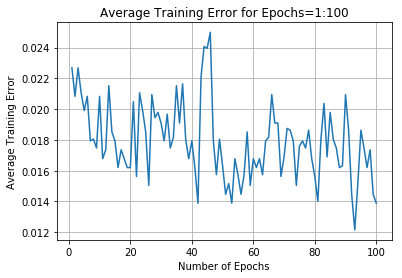

In [17]:
plt.figure()
plt.plot(np.linspace(start=1, stop=num_epochs, num=num_epochs), avg_error_vec)
plt.xlabel("Number of Epochs")
plt.ylabel("Average Training Error")
plt.title("Average Training Error for Epochs=1:100")
plt.grid(True)
# plt.savefig("Neural Net Training Error.jpg")

## Evaluate model on testing set

In [18]:
best_model.eval()

for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    predictions = best_model(samples)
    predictions = torch.flatten(predictions)
    labels = labels.type(torch.DoubleTensor)

    for j in range(0, predictions.size()[0]):
        if predictions[j] < 0.5:
            predictions[j] = 0
        else:
            predictions[j] = 1
    
    error = 1 - torch.sum(predictions == labels).item() / labels.size()[0]
    
    print("Testing set Error: %0.4f" % error)
    
model_path = dest_path + "torch_model_4_6_19_lr=" + str(learning_rate) + "_dict.pt"

Testing set Error: 0.1370


### Save Model

In [19]:
torch.save(model.state_dict(), model_path)

### Load and Evaluate previous models

In [6]:
model = CLANet(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(dest_path + "torch_model_3_11_19_lr=0.001_dict.pt"))
model.double()     # cast model parameters to double
model.eval()

for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    conf = model(samples)
    conf = torch.flatten(conf)
    labels = labels.type(torch.DoubleTensor)
    
    for j in range(conf.size()[0]):
        if conf[j] < 0.5:
            conf[j] = 0
        else:
            conf[j] = 1
                
    error = 1 - torch.sum(conf == labels).item() / labels.size()[0]
    
    print("Testing set Error: %0.4f" % error)

NameError: name 'dest_path' is not defined

## Best Model Evaluation

In [139]:
model = CLANet(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("torch_model_3_10_19_lr=0.001_dict.pt"))
model.double()     # cast model parameters to double
model.eval()

for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    conf = model(samples)    # confidence that a certain instance is predicted correctly
    conf = torch.flatten(conf)
    labels = labels.type(torch.DoubleTensor)
    
# convert to numpy arrays
conf = conf.detach().numpy()
labels = labels.numpy()

# sort arrays according to the predicted confidence (high confidence to low confidence)
sort_idx = np.argsort(-conf, kind='mergesort')
conf = conf[sort_idx]
labels = labels[sort_idx]

### ROC Curve

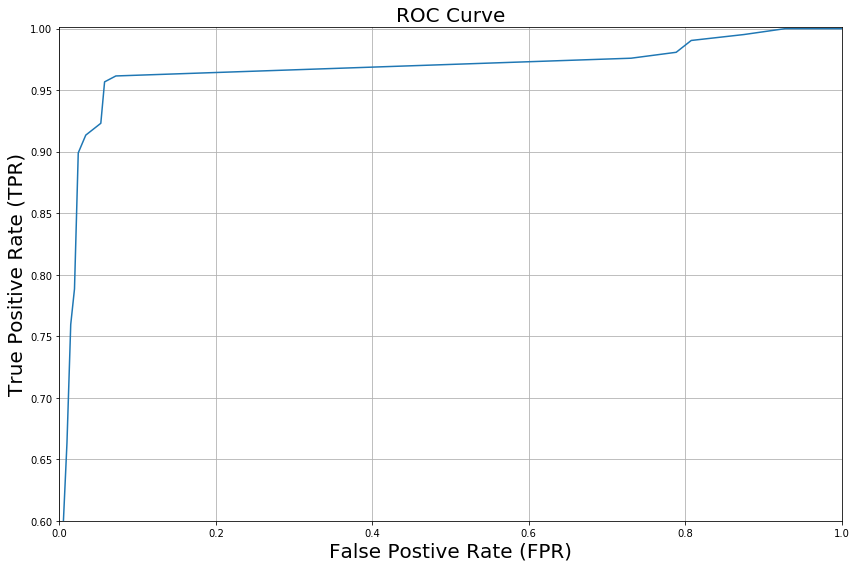

In [140]:
num_pos = 0
num_neg = 0

for label in labels:
    if label < 0.5:
        num_neg += 1
    else:
        num_pos += 1
        
tp = 0
fp = 0
last_tp = 0
fpr = []
tpr = []

for i in range(len(labels)):
    if (i > 1) and (conf[i] != conf[i-1]) and (labels[i] == 0) and (tp > last_tp):
        fpr.append(fp / num_neg)
        tpr.append(tp / num_pos)
        last_tp = tp
    if labels[i] == 1:
        tp += 1
    else:
        fp += 1
        
fpr.append(fp / num_neg)
tpr.append(tp / num_pos)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.xlabel('False Postive Rate (FPR)', fontsize=20)
plt.ylabel('True Positive Rate (TPR)', fontsize=20)
plt.axis([0, 1, 0.6, 1.001])
plt.title('ROC Curve', fontsize=20)
plt.tight_layout()
plt.grid(True)

### PR Curve

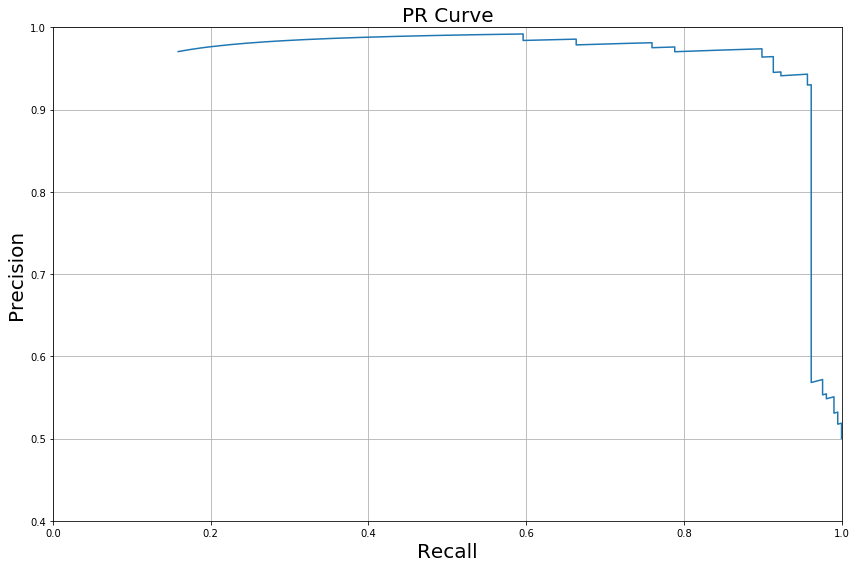

In [142]:
for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    pred = model(samples)
    pred = torch.flatten(pred)
    labels = labels.type(torch.DoubleTensor)

# convert to numpy arrays
pred = pred.detach().numpy()
labels = labels.numpy()

# sort arrays according to the predicted confidence (high confidence to low confidence)
sort_idx = np.argsort(-pred, kind='mergesort')
pred = pred[sort_idx]
labels = labels[sort_idx]

num_pred_pos = 0
num_actual_pos = 0
num_tp = 0
precision = []
recall = []

for confidence in conf:
    for i in range(len(pred)):
        if pred[i] >= confidence:
            num_pred_pos += 1
            
            if labels[i] == 1:
                num_tp += 1
        
        if labels[i] == 1:
            num_actual_pos += 1

    precision.append(num_tp / num_pred_pos)
    recall.append(num_tp / num_actual_pos)
    
    num_pred_pos = 0
    num_actual_pos = 0
    num_tp = 0

plt.figure(figsize=(12, 8))
plt.plot(recall, precision)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.axis([0, 1.001, 0.4, 1])
plt.title('PR Curve', fontsize=20)
plt.tight_layout()
plt.grid(True)

## Test best model on other data sets

### Read in data

In [51]:
# define data path
data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
data_set = "data_2014_summer"

# load data sets
X = np.load(data_path + data_set + ".npy")
y = np.load(data_path + data_set + "_labels.npy")

# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: -1 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# oversample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
idx = 0
sample_bias = 0
length_y = len(y)
while num_alg != (num_no_alg + sample_bias):
    # circle through the data sets until the difference of num_no_alg and num_alg equals
    # the value specified by sample_bias
    if idx == (length_y - 1):
        idx = 0

    if y[idx] == 1:
        if np.random.rand() >= 0.5:  # add this sample with some probability
            y = np.append(y, y[idx])
            X = np.append(X, np.reshape(X[idx, :], newshape=(1, num_features)), axis=0)
            num_alg += 1
        else:
            idx += 1
    else:
        idx += 1

### Process and split data

In [52]:
# standardize data: remove the mean and variance in each sample
num_splits = 2   # do not change
sss = model_selection.StratifiedShuffleSplit(n_splits=num_splits, test_size=test_size)

idx, _ = sss.split(X, y);
train_idx = idx[0]
test_idx = idx[1]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)

# convert numpy arrays to pytorch tensors
train_set_size = X_train.shape
test_set_size = X_test.shape
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

# convert pytorch tensors to pytorch TensorDataset
train_set = utils.TensorDataset(X_train, y_train)
test_set = utils.TensorDataset(X_test, y_test)

# create DataLoaders
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = utils.DataLoader(test_set, batch_size=test_set_size[0], shuffle=True)

### Evaluate best model

In [53]:
for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    conf = model(samples)
    conf = torch.flatten(conf)
    labels = labels.type(torch.DoubleTensor)
    
    for j in range(conf.size()[0]):
        if conf[j] < 0.5:
            conf[j] = 0
        else:
            conf[j] = 1
                
    error = 1 - torch.sum(conf == labels).item() / labels.size()[0]
    
    print("Testing set Error: %0.4f" % error)

Testing set Error: 0.4688


### Optimizer parameter adjust

In [9]:
for p in optimizer.param_groups:
    p["lr"] = 0.0003
    p["momentum"] = 0.5

In [12]:
for p in optimizer.param_groups:
    p["lr"] = 0.0001
    p["momentum"] = 0.2

In [15]:
for p in optimizer.param_groups:
    p["lr"] = 0.00005
    p["momentum"] = 0

In [38]:
for p in optimizer.param_groups:
    p["lr"] = 0.0000005